In [1]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\agarw\anaconda3\envs\MasterEnv\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
  stacklevel=1)


Using device: cuda

GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
from collections import Counter
import ipywidgets as widgets
import json
import csv
import pandas as pd
from urllib.request import urlopen


In [3]:
# Extract projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects)} projects")
projects.head()


955 projects


,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [4]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects_tags)} projects")
projects_tags.head()

955 projects


,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [5]:
df = pd.concat([projects, projects_tags], axis=1)
df = df.T.drop_duplicates().T
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [6]:
# Remove projects with no tag
df = df[df.tag.notnull()]

In [7]:
df.to_csv("labeled_projects.csv", index=False)

In [8]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [9]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags_dict = {}
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation
for item in projects_tags.tag:
    tags_dict[item] = item

print (f"{len(tags_dict)} tags")

6 tags


In [10]:
tags_dict

{'computer-vision': 'computer-vision',
 'graph-learning': 'graph-learning',
 'reinforcement-learning': 'reinforcement-learning',
 'natural-language-processing': 'natural-language-processing',
 'mlops': 'mlops',
 'time-series': 'time-series'}

# Exploration(EDA)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

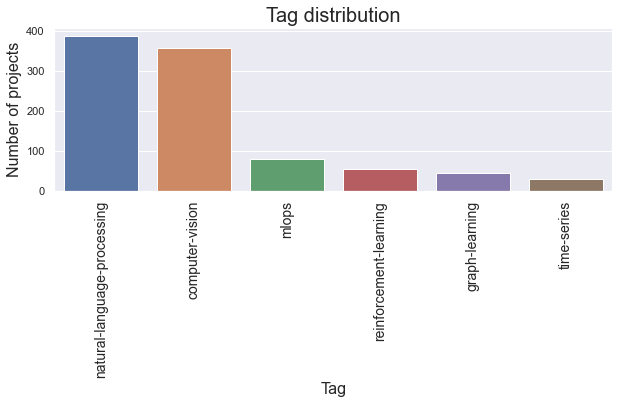

In [12]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [13]:
# Wordcloud representation
def display_word_cloud(tag:"natural-language-processing"):
    plt.figure(figsize=(15,5))
    subset = df[df.tag == tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

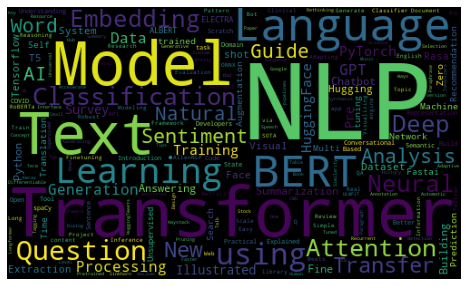

In [14]:
display_word_cloud("natural-language-processing")

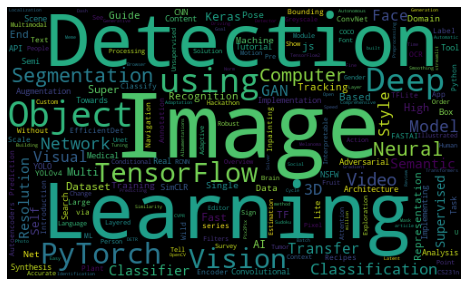

In [15]:
display_word_cloud("computer-vision")

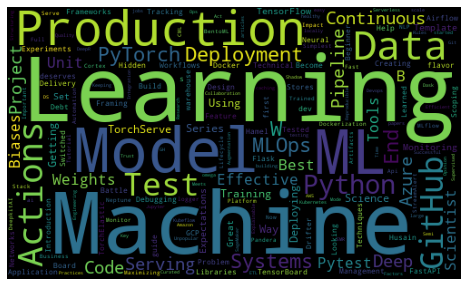

In [16]:
display_word_cloud("mlops")

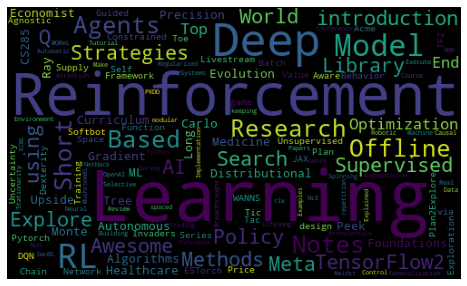

In [17]:
display_word_cloud("reinforcement-learning")

# Labelling

In [18]:
# Min frequency
min_freq = 75
tags = Counter(df.tag.values)

In [19]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [20]:
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)

In [21]:
# Fill None with other
df.tag = df.tag.fillna("other")

In [22]:
# Now we have tags with values Computer Vision, NLP, mlops, others
df.head(10)

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other
5,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
6,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other
7,27,2020-03-07 23:18:15,APPNP and PPNP,"A PyTorch implementation of ""Predict then Prop...",other
8,28,2020-03-07 23:23:46,Attributed Social Network Embedding,A sparsity aware and memory efficient implemen...,other
9,29,2020-03-07 23:45:38,Signed Graph Convolutional Network,"A PyTorch implementation of ""Signed Graph Conv...",other


# Preprocessing

In [23]:
# Feature Engineering
df["text"] = df.title + " " + df.description 

In [24]:
df.head(5)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...


In [25]:
! pip install nltk==3.7 -q

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [27]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [29]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [30]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


# Encoding

In [31]:
import numpy as np
import random

In [32]:
# Get data
X = df.text.to_numpy()
y = df.tag

In [33]:
class LabelEncoder(object):
    """Encode labels into unique indices."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [35]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [36]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [37]:
# Tesing the encoded domain
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [38]:
# Tesing the decoded domain
label_encoder.decode([0, 1, 2])

['computer-vision', 'mlops', 'natural-language-processing']

In [39]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [40]:
X

array(['comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes',
       'show infer tell contextual inference creative captioning beauty work lies way architects fundamental idea humans look overall image individual pieces',
       'awesome graph classification collection important graph embedding classification representation learning papers implementations',
       'awesome monte carlo tree search curated list monte carlo tree search papers implementations',
       'diffusion vector reference implementation diffusion2vec complenet 2018 built gensim networkx',
       'attentionwalk pytorch implementation watch step learning node embeddings via graph attention neurips 2018',
       'graph wavelet neural network pytorch implementation graph wavelet neural network iclr 2019',
       'appnp ppnp pytorch implementation predict propagate graph neural networks meet personalized pagerank iclr 2019',
       'attributed social netwo

In [41]:
y

array([0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3,
       2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 3, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2,
       0, 3, 2, 0, 2, 0, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 3, 2, 3, 3, 0, 2, 0, 0, 3, 3, 2, 2,
       2, 2, 2, 3, 0, 2, 0, 0, 0, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 3,
       3, 3, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 3, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 3, 0, 3, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2,
       0, 2, 0, 1, 2, 3, 1, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 0, 2, 2, 2, 3,
       3, 3, 2, 0, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 3, 3, 2, 2, 2, 3,
       0, 3, 2, 2, 2, 0, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 2, 0, 0, 3, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0,

# Splitting the dataset into Train, Val and Test 

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [44]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [45]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [46]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [47]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [48]:

# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [49]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [50]:
X_train

array(['spektral graph neural networks keras tensorflow 2',
       'gpt 3 model simply knows brief introduction gigantic gpt 3 new leap ai natural language processing',
       'million ml predictions tip fingers announcement sashido breaking barrier machine learning introducing fully open sourced content moderation service',
       'allennlp interpret framework explaining predictions nlp models',
       'zero shot neural retrieval via domain targeted synthetic queries zero shot learning ad hoc retrieval models relies synthetic query generation',
       'cognito data wrangling toolkit cognito exclusive python data preprocessing library command line utility helps developer transform raw data machine learning format',
       'spaczz fuzzy matching spacy fuzzy matching functionality spacy',
       'getting started time series analysis using pandas introductory guide get started time series datasets python',
       'summary transformers models high level summary differences model huggingfac

In [51]:
y_train

array([3, 2, 0, 2, 2, 3, 2, 3, 2, 3, 1, 0, 2, 0, 2, 2, 2, 3, 2, 2, 0, 3,
       2, 3, 0, 0, 0, 2, 2, 3, 2, 3, 2, 0, 0, 1, 3, 2, 0, 3, 0, 2, 1, 0,
       2, 1, 0, 0, 3, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0,
       0, 2, 3, 0, 1, 2, 2, 0, 2, 2, 0, 3, 0, 2, 3, 0, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 3, 1, 2, 2,
       2, 0, 1, 0, 2, 3, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 3, 2, 0, 0, 0,
       0, 2, 0, 3, 2, 0, 2, 2, 1, 2, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0,
       1, 0, 2, 0, 0, 2, 2, 3, 0, 0, 2, 2, 2, 3, 0, 0, 3, 0, 2, 0, 2, 1,
       0, 0, 3, 2, 3, 2, 1, 3, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 3, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 3, 2, 1, 1, 3, 2,
       0, 3, 1, 0, 2, 3, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 3, 0, 0,
       2, 0, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 3, 2,
       0, 2, 3, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 3, 3, 2, 0, 0, 3, 2,
       2, 2, 2, 3, 2, 2, 0, 2, 0, 0, 3, 2, 2, 3, 2,

In [52]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,spektral graph neural networks keras tensorflow 2,other
1,gpt 3 model simply knows brief introduction gi...,natural-language-processing
2,million ml predictions tip fingers announcemen...,computer-vision
3,allennlp interpret framework explaining predic...,natural-language-processing
4,zero shot neural retrieval via domain targeted...,natural-language-processing


In [53]:
test_df.head()

,text,tag
0,illustrated gpt 2 visualizing transformer lang...,natural-language-processing
1,superglue learning feature matching graph neur...,other
2,attribute2font creating fonts want attributes ...,natural-language-processing
3,sktime python toolbox machine learning time se...,other
4,natural language processing roadmap roadmap le...,natural-language-processing


In [54]:
val_df.head()

,text,tag
0,awesome graph classification collection import...,other
1,gpt 3 language model technical overview techni...,natural-language-processing
2,artifacts weights biases effortless pipeline t...,mlops
3,movie recommendation system web app recommends...,natural-language-processing
4,cybert applying bert windows event logs blog s...,natural-language-processing


# Augmentation

In [55]:
! pip install nlpaug==1.1.0 transformers==3.0.2 -q
! pip install snorkel==0.9.8 -q

In [56]:
import nlpaug.augmenter.word as naw

In [57]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [58]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(substitution.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
integrated image generation enables variational autoencoders laser printers.
conditional timer generation offers variational autoencoders plus sensors.
integrating data generation using interactive autoencoders and processors.
standard model generation involves variational autoencoders dubbed gans.
conditional frame generation use variational autoencoders overhead antennas.
reverse image transformations using random transitions and gans.
conditional image scanning using robotic autoencoders with antennas.
conditional image mapping using digital transformation as gans.
conditional code generation involves variational autoencoders analysis algorithms.
using functional analysis using variational equations and gans.


In [59]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(insertion.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
conditional image filter generation implementations using 2d variational fourier autoencoders and gans.
generate conditional adaptive image generation algorithms using variational autoencoders and sample gans.
conditional transmission image generation using binary variational orthogonal autoencoders arrays and gans.
prediction conditional on image generation using variational temporal autoencoders and sample gans.
conditional nonlinear image generation generation using nonlinear variational autoencoders arrays and gans.
conditional image generation method using variational binary autoencoders capture and conditional gans.
performs conditional 3d image generation using variational function autoencoders operators and gans.
conditional image filter generation using discrete variational autoencoders commands and binary gans.
serial conditional image buffer generation per

We can use aliases to transform the text, using snorkel's transformation function.

In [60]:
def replace_dash(x):
    return x.replace("-", " ")

In [61]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [62]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [63]:
print(flattened_aliases)

{'computer vision': ['cv', 'vision'], 'cv': ['vision', 'computer vision'], 'vision': ['cv', 'computer vision'], 'mlops': ['production'], 'production': ['mlops'], 'natural language processing': ['nlp', 'nlproc'], 'nlp': ['nlproc', 'natural language processing'], 'nlproc': ['nlp', 'natural language processing']}


In [64]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [65]:
from snorkel.augmentation import transformation_function

In [66]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [67]:
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks
survey reinforcement learning nlproc tasks


In [68]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc
autogenerate cv apply jobs using natural language processing


In [69]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [70]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:01<00:00, 428.24it/s]


,text,tag
0,spektral graph neural networks keras tensorflow 2,other
1,gpt 3 model simply knows brief introduction gi...,natural-language-processing
1,gpt 3 model simply knows brief introduction gi...,natural-language-processing
1,gpt 3 model simply knows brief introduction gi...,natural-language-processing
2,million ml predictions tip fingers announcemen...,computer-vision


In [71]:

len(train_df), len(train_df_augmented)

(668, 919)

# Modeling

We will start with a very basic model and then we will try to enhance the model for our use case

In [72]:
import random
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)

In [73]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [74]:
def preprocess(df, lower, stem, min_freq):
    df["text"] = df.title  + " " + df.description
    df.text = df.text.apply(clean_text, lower=lower,stem=stem)

    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    print(oos_tags)
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.tag.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df




In [75]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Baseline Model

In [76]:
from sklearn.metrics import precision_recall_fscore_support

In [77]:
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True,stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [78]:
X_train

array(['laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections',
       'extract stock sentiment news headlines project generate investing insight applying sentiment analysis financial news headlines finviz',
       'big bad nlp database collection 400 nlp datasets papers included',
       'job classification job classification done using techniques nlp ml dataset used kaggle indeeed job posting',
       'optimizing mobiledet mobile deployments learn criticalities effectively optimizing mobiledet object detectors mobile deployments',
       'multimodal meme classification uniter given state art results various image text related problems project aims finetuning uniter solve hateful memes challenge',
       'gans computer vision article review series article series review important research papers gans 2015 today 6 articles 20 papers 20000 words',
       'almost everything

In [79]:
y_train

array([0, 2, 2, 2, 0, 0, 0, 3, 1, 2, 2, 2, 2, 3, 2, 0, 0, 1, 2, 3, 0, 3,
       0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 3, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 0, 3, 2, 2, 0, 2,
       0, 2, 1, 2, 3, 2, 0, 0, 2, 2, 2, 3, 0, 0, 2, 3, 0, 1, 1, 2, 1, 1,
       2, 2, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 3, 0, 2, 3,
       3, 0, 0, 2, 2, 2, 2, 0, 2, 3, 3, 2, 1, 3, 3, 0, 2, 2, 0, 0, 0, 2,
       0, 1, 0, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 0, 3,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 3, 3, 2, 0, 2, 0, 2, 3, 2, 1, 0, 0, 0, 0, 2, 0, 2,
       2, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 3, 2, 2, 2, 0, 3, 2, 3, 0, 2, 2, 2,
       2, 0, 2, 3, 0, 3, 2, 2, 3, 2, 0, 2, 0, 0, 0, 2, 3, 2, 0, 1, 2, 2,
       2, 0, 0, 0, 2, 1, 0, 1, 1, 3, 3, 2, 3, 2, 0, 0, 3, 0, 1, 3, 2, 0,
       0, 3, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2,

In [80]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [81]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred)

(144,)
[2 2 1 3 3 3 3 3 1 2 2 1 3 1 2 0 1 3 2 2 2 2 3 0 2 1 0 2 0 1 2 1 3 2 2 2 2
 3 2 0 2 3 2 0 3 3 0 0 0 0 0 3 3 2 2 1 2 2 0 0 2 1 0 2 2 3 1 3 1 0 1 2 2 1
 1 1 3 1 0 3 3 1 0 3 2 3 1 0 1 2 2 2 1 3 1 0 3 2 1 2 2 0 3 0 0 0 2 0 0 3 3
 0 3 3 0 2 0 3 2 1 2 3 2 0 1 1 1 3 3 1 2 1 2 2 3 2 1 3 0 0 3 1 0 0]


In [82]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2844744487889649,
  "recall": 0.22916666666666666,
  "f1": 0.24552884283001275
}


In [83]:
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
print(p)

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]


# Rule based predictions

In [84]:

# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


# Vectorization

In [85]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
dataset = [
    "I enjoy reading about Machine Learning and Machine Learning is my PhD subject",
    "I would enjoy a walk in the park",
    "I was reading in the library"
]

In [86]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df)

            TF-IDF
machine   0.513720
learning  0.513720
about     0.256860
subject   0.256860
phd       0.256860
and       0.256860
my        0.256860
is        0.256860
reading   0.195349
enjoy     0.195349
library   0.000000
park      0.000000
in        0.000000
the       0.000000
walk      0.000000
was       0.000000
would     0.000000


In [87]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [88]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [89]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train[0])
print (X_train.shape)  # scipy.sparse.csr_matrix

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
  (0, 27075)	0.03486417410747293
  (0, 59397)	0.037070483947105486
  (0, 61797)	0.037070483947105486
  (0, 66741)	0.037070483947105486
  (0, 20170)	0.037070483947105486
  (0, 1777)	0.037070483947105486
  (0, 69944)	0.037070483947105486
  (0, 45966)	0.037070483947105486
  (0, 48730)	0.037070483947105486
  (0, 82999)	0.037070483947105486
  (0, 6456)	0.037070483947105486
  (0, 80656)	0.037070483947105486
  (0, 32521)	0.037070483947105486
  (0, 81967)	0.037070483947105486
  (0, 93476)	0.037070483947105486
  (0, 7558)	0.037070483947105486
  (0, 22293)	0.037070483947105486
  (0, 42253)	0.037070483947105486
  (0, 55697)	0.037070483947105486
  (0, 12496)	0.037070483947105486
  (0, 74148)	0.037070483947105486
  (0, 3948)	0.03486417410747293
  (0, 21788)	0.037070483947105486
  (0, 27441)	0.037070483947105486
  (0, 81591)	0.0370

In [90]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [249  55 272  92],
class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


# Data Imbalance

In [91]:
! pip install imbalanced-learn==0.8.1 -q

In [92]:
from imblearn.over_sampling import RandomOverSampler

In [93]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [94]:
import matplotlib.pylab as plt

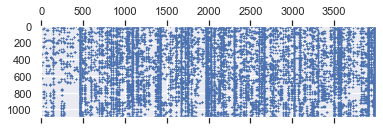

In [95]:
plt.spy(X_over[:,0:4000],markersize=0.5)

In [96]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


# Machine Learning
We are going to use SGD with log loss, which is basically logistic loss

In [97]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [98]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="optimal", eta0=1e-1, power_t=0.1, 
    warm_start=True)

In [99]:
# Train model
num_epochs = 5000
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 0.12565, val_loss: 0.39472
Epoch: 10 | train_loss: 0.12973, val_loss: 0.40077
Epoch: 20 | train_loss: 0.12325, val_loss: 0.39595
Epoch: 30 | train_loss: 0.13204, val_loss: 0.40479
Epoch: 40 | train_loss: 0.11880, val_loss: 0.38008
Epoch: 50 | train_loss: 0.13180, val_loss: 0.38998
Epoch: 60 | train_loss: 0.11787, val_loss: 0.38785
Epoch: 70 | train_loss: 0.12742, val_loss: 0.39450
Epoch: 80 | train_loss: 0.12612, val_loss: 0.39527
Epoch: 90 | train_loss: 0.12051, val_loss: 0.39132
Epoch: 100 | train_loss: 0.13434, val_loss: 0.40580
Epoch: 110 | train_loss: 0.11932, val_loss: 0.40043
Epoch: 120 | train_loss: 0.12565, val_loss: 0.39482
Epoch: 130 | train_loss: 0.11483, val_loss: 0.38106
Epoch: 140 | train_loss: 0.11669, val_loss: 0.38209
Epoch: 150 | train_loss: 0.12031, val_loss: 0.39668
Epoch: 160 | train_loss: 0.12609, val_loss: 0.39952
Epoch: 170 | train_loss: 0.12471, val_loss: 0.38859
Epoch: 180 | train_loss: 0.12086, val_loss: 0.39821
Epoch: 190 | train_los

In [100]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.874609042159669,
  "recall": 0.875,
  "f1": 0.8735469896460608
}


In [101]:

# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [102]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.02351830400423087,
 'mlops': 0.003910477619280936,
 'natural-language-processing': 0.9616269158473808,
 'other': 0.010944302529107273}

In [103]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1
threshold

0.7103890340506117

In [104]:
# Evaluate
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults 
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=label_encoder.class_to_index["other"])
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9042181069958848,
  "recall": 0.7569444444444444,
  "f1": 0.7907514466337996
}


# Evaluation
So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

Coarse-grained metrics\
Fine-grained metrics\
Confusion matrix\
Confidence learning\
Slice metrics

In [105]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [106]:
# Data to evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)

In [107]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9042181069958848,
    "recall": 0.7569444444444444,
    "f1": 0.7907514466337996,
    "num_samples": 144.0
}


In [108]:

from collections import OrderedDict

In [109]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [110]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7586206896551724,
    "f1": 0.8627450980392156,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.37037037037037035,
    "recall": 1.0,
    "f1": 0.5405405405405406,
    "num_samples": 20.0
  }
]


In [111]:
# TP, FP, FN samples
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [112]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [113]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}")

pytest pytest framework makes easy write small tests yet scales support complex functional testing
true: mlops
pred: mlops


In [114]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag="mlops"):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))

    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i, true in enumerate(y_test):
        pred = y_pred[i]
        if index==true==pred:
            tp.append(i)
        elif index!=true and index==pred:
            fp.append(i)
        elif index==true and index!=pred:
            fn.append(i)

    # Samples
    num_samples = 3
    cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
    for item in cm:
        if len(item[0]):
            print (f"\n=== {item[1]} ===")
            for index in item[0][:num_samples]:
                print (f"  {X_test_raw[index]}")
                print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
                print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")

interactive(children=(Dropdown(description='tag', index=1, options=('natural-language-processing', 'mlops', 'c…

# Confidence Learning

In [115]:
# y
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [116]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

In [117]:

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

In [118]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i], 
                               "true": label_encoder.index_to_class[y_test[i]], 
                               "pred": label_encoder.index_to_class[y_pred[i]], 
                               "prob": prob})

In [119]:
low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.36374216496858813}]

In [120]:

! pip install cleanlab==1.0.1 -q

In [121]:
import cleanlab
from cleanlab.pruning import get_noise_indices

In [122]:
# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test, 
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)

In [123]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other



In [124]:
! pip install snorkel==0.9.8 


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [125]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [126]:
@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)

In [127]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [128]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 17939.28it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [129]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 23870.83it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [130]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 8470.49it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [131]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [132]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.6,
    "recall": 0.6,
    "f1": 0.6,
    "num_samples": 5
  }
}


# Interpretabality

In [133]:

! pip install lime==0.2.0.1 -q

In [134]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [135]:
# Create pipeline
pipe = make_pipeline(vectorizer, model)

In [136]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

# Behavioral Testing

In [137]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)

In [138]:

# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [139]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']

# Experiment Tracking

In [141]:
! pip install mlflow==1.13.1 --user -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
